# Preparation

In [1]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video

In [2]:
DATASET_PATH = "/kaggle/input/snooker-balls/balls"
OUTPUT_PATH = "/kaggle/working"

# Dataset 

### Original Dataset Structure
Dataset structure is given in next format:
```
snooker-balls/balls/
    train/
        {class1}/
            {id_1}.jpg
            {id_2}.jpg
            ...
        {class2}/
            ...
        ...
    test/
    ...
```

### Yolo Dataset Structure
Dataset structure should be transformed to next format:
```
yolo_dataset/
    images/
        train/
            {class1}_{id_1}.jpg
            {class1}_{id_2}.jpg
            ...
        val/
            ...
    labels/
        train/
            {class1}_{id_1}.txt
            {class1}_{id_2}.txt
            ...
        val/
            ...
```

In [3]:
# root directory to save dataset in yolo format
root_dir=os.path.join(OUTPUT_PATH,"yolo_dataset")
os.makedirs(root_dir, exist_ok=True)

# train and test subdirectories with image directory
images_dir=os.path.join(root_dir,"images")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(images_dir+"/train", exist_ok=True)
os.makedirs(images_dir+"/val", exist_ok=True)

# train and test subdirectories with label directory
labels_dir=os.path.join(root_dir,"labels")
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(labels_dir+"/train", exist_ok=True)
os.makedirs(labels_dir+"/val", exist_ok=True)

In [4]:
# variables to convert label/id to id/label
label2id = {"black": 0, "blue": 1, "brown": 2, "green": 3, "pink": 4, "red": 5, "white": 6, "yellow": 7}
id2label = {v: k for k, v in label2id.items()}

In [37]:
for layer1 in os.listdir(DATASET_PATH):
    for layer2 in os.listdir(f'{DATASET_PATH}/{layer1}'):
        for layer3 in os.listdir(f'{DATASET_PATH}/{layer1}/{layer2}'):
            if layer3.endswith('.jpg'):
                shutil.copyfile(f'{DATASET_PATH}/{layer1}/{layer2}/{layer3}',f'{images_dir}/{layer1}/{layer2}_{layer3}'.replace('test', 'val' ))
                f = open(f'{labels_dir}/{layer1}/{layer2}_{layer3}'[:-4].replace('test', 'val' )+'.txt', 'w')
                f.write(str(label2id[layer2])+' 0.5 0.5 1 1')
                f.close()

# YOLOv8

In [6]:
!pip install ultralytics
!yolo checks
from ultralytics import YOLO

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/98/44/71231f2da4fb4a602d0cef2071adb708199e571ef89ed4a136f59c19d733/ultralytics-8.0.231-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 26.4 MB/s eta 0:00:00
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5310.5/8062.4 GB disk)

OS                  Linux-5.15.133+-x86_64-with-glibc2.31
Environment         Kaggle
Python              3.10.12
Install             pip
RAM                 31.36 GB
CPU                 Intel Xeon 2.20GHz
CUDA                None

matplotlib          ✅ 3.7.4>=3.3.0
numpy               ✅ 1.24.3>=1.22.2
opencv-python       ✅ 4.8.1.78>=4.6.0
pillow              ✅ 9.5.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.0.0+cpu>=1.8.0
torchvision         ✅ 0.15.1+cpu>=0.9.0
t

### Convert Dataset to Yolo Format

In [7]:
names_content = "\n".join([f"  {label_id}: {label}" for label, label_id in label2id.items()])
dataset_content = f"""
path: "{root_dir}/"
train: "images/train"
val: "images/val"
names:
{names_content}
"""
with open(os.path.join(OUTPUT_PATH, "custom_dataset.yaml"), "w") as f:
    f.write(dataset_content)

### Train the Model

In [39]:
# pretrained model: yolov8n、yolov8s、yolov8m、yolov8l、yolov8x
model = YOLO('yolov8n-p6.yaml').load('yolov8n.pt')

# Train the model using the processed dataset
results = model.train(
    data=os.path.join(OUTPUT_PATH,'custom_dataset.yaml'),
    project='snooker_project',
    exist_ok=True,
    epochs=10,
    batch=16,
    imgsz=32,
    optimizer='Adam',
    lr0=0.001,
    lrf=0.0005
)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    221568  ultralytics.nn.modules.conv.Conv             [128

wandb: Currently logged in as: yustinachang. Use `wandb login --relogin` to force relogin


Freezing layer 'model.30.dfl.conv.weight'
WARNING ⚠️ imgsz=[32] must be multiple of max stride 64, updating to [64]


train: Scanning /kaggle/working/yolo_dataset/labels/train... 11510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11510/11510 [00:09<00:00, 1158.92it/s]


train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset/labels/val... 2873 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2873/2873 [00:02<00:00, 1205.34it/s]


val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache
Plotting labels to snooker_project/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 75 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
WARNING ⚠️ TensorBoard graph visualization failure Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.7671     0.9907      1.273          6         64: 100%|██████████| 720/720 [03:06<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:26<00:00,  3.36it/s]


                   all       2873       2873      0.785      0.771      0.899      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       0.34     0.4421     0.9596          6         64: 100%|██████████| 720/720 [03:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:26<00:00,  3.45it/s]


                   all       2873       2873      0.739      0.841      0.945      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.2956     0.3505     0.9255          6         64: 100%|██████████| 720/720 [04:53<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:25<00:00,  3.51it/s]


                   all       2873       2873      0.765      0.893      0.918      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.2654     0.2866     0.9142          6         64: 100%|██████████| 720/720 [04:24<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:25<00:00,  3.57it/s]


                   all       2873       2873      0.698      0.896       0.95      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.2491     0.2702      0.906          6         64: 100%|██████████| 720/720 [03:10<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:25<00:00,  3.56it/s]


                   all       2873       2873       0.86      0.856      0.943      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.2288     0.2375     0.9011          6         64: 100%|██████████| 720/720 [03:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:25<00:00,  3.56it/s]


                   all       2873       2873      0.699      0.927      0.958      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.2114     0.2126      0.896          6         64: 100%|██████████| 720/720 [03:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:30<00:00,  2.95it/s]


                   all       2873       2873      0.803      0.948      0.986      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.2044     0.1988     0.8904          6         64: 100%|██████████| 720/720 [02:56<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:31<00:00,  2.88it/s]


                   all       2873       2873      0.771      0.962      0.981      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.1945     0.1817     0.8881          6         64: 100%|██████████| 720/720 [02:55<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:25<00:00,  3.59it/s]


                   all       2873       2873      0.842      0.948      0.984      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.1871     0.1678     0.8881         16         64:  79%|███████▉  | 572/720 [02:11<00:34,  4.34it/s]


KeyboardInterrupt: 

### Validate the Model

In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

### Export the Model with **ONNX**

In [ ]:
model.export(format='onnx')

### Benchmark the Model with **ONNX**

In [ ]:
from ultralytics.utils.benchmarks import benchmark
benchmark(model='snooker_project/train/weights/best.pt', imgsz=128)

### Create a Download Link

In [ ]:
%cd $OUTPUT_PATH
!zip -r snooker_project.zip snooker_project
from IPython.display import FileLink
FileLink(r'snooker_project.zip')

# Image from Test

In [25]:
image = '/kaggle/input/snooker-private-test/image2.jpg'

In [30]:
%cd $OUTPUT_PATH
best_model = YOLO("snooker_project/train/weights/best.pt")
best_model.predict(source=image, show=False, save=True, name='image', exist_ok=True)

/kaggle/working

image 1/1 /kaggle/input/snooker-balls/balls/test/black/ball_1042.jpg: 64x64 1 black, 15.2ms
Speed: 0.5ms preprocess, 15.2ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 64)
Results saved to runs/detect/image


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'black', 1: 'blue', 2: 'brown', 3: 'green', 4: 'pink', 5: 'red', 6: 'white', 7: 'yellow'}
 orig_img: array([[[  3, 129,  10],
         [  4, 130,  11],
         [  7, 129,  11],
         ...,
         [ 16, 125,  16],
         [ 11, 125,  11],
         [  8, 129,   7]],
 
        [[  6, 129,  11],
         [  4, 127,   9],
         [  5, 127,   9],
         ...,
         [ 15, 124,  16],
         [ 11, 125,  12],
         [  8, 129,   7]],
 
        [[  8, 130,  12],
         [  5, 127,   9],
         [  9, 126,  11],
         ...,
         [ 17, 122,  17],
         [ 13, 125,  15],
         [  9, 129,  10]],
 
        ...,
 
        [[ 15, 126,  18],
         [ 12, 117,  14],
         [  9, 103,   8],
         ...,
         [ 20, 110,  20],
         [ 16, 121,  18],
         [  9, 132,  12]],
 
        [[ 10, 125,  15],
         [  7, 

/kaggle/working


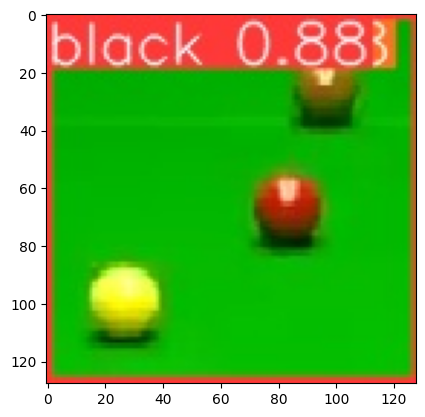

In [38]:
%cd $OUTPUT_PATH
plt.imshow(cv2.cvtColor(cv2.imread('runs/detect/image/image2.jpg'), cv2.COLOR_BGR2RGB))
plt.show()

# Video with PyTube

In [ ]:
!pip install pytube
from pytube import YouTube
YouTube('https://youtu.be/hw02UKK4Kb0').streams.filter().get_highest_resolution().download(output_path=OUTPUT_PATH, filename='youtube.mp4')

In [ ]:
%cd $OUTPUT_PATH
!ffmpeg -i youtube.mp4 -vcodec copy -acodec copy -ss 00:01:05 -to 00:01:15 video.mp4 -y

In [ ]:
%cd $OUTPUT_PATH
Video('video.mp4', width=840)

In [14]:
#video = os.path.join(OUTPUT_PATH, 'video.mp4')
video = '/kaggle/input/snooker-private-test/video.mp4'

# Predict the Video

In [16]:
%cd $OUTPUT_PATH
best_model = YOLO("snooker_project/train/weights/best.pt")
best_model.predict(source=video, show=False, save=True, name='predict', exist_ok=True)

/kaggle/working


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/226) /kaggle/input/snooker-test-video/video.mp4: 64x64 1 white, 22.1ms
video 1/1 (2/226) /kaggle/input/snooker-test-video/video.mp4: 64x64 1 white, 15.1ms
video 1/1 (3/226) /kaggle/input/snooker-test-video/video.mp4: 64x64 1 white, 12.4ms
video 1/1 (4/226) /kaggle/input/snooker-test-video/video.mp4: 64x64 1 white, 12.4ms
video 1/1 (5/226) /kaggle/input/snooker-test-video/video.mp4: 64x64 1 green, 1 white, 11.9ms
video 1/1 (

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'black', 1: 'blue', 2: 'brown', 3: 'green', 4: 'pink', 5: 'red', 6: 'white', 7: 'yellow'}
 orig_img: array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        ...,
 
        [[84, 90, 85],
         [84, 90, 85],
         [84, 90, 85],
         ...,
         [90, 96, 91],
         [90, 96, 91],
         [90, 96, 91]],
 
        [[84, 90, 85],
         [84, 90, 85],
         [84, 90, 85],
         ...,
         [90, 96, 91],
       

In [17]:
%cd $OUTPUT_PATH
!ffmpeg -y -loglevel panic -i runs/detect/predict/video.avi predict_video.mp4
# Display the video 
Video("predict_video.mp4", width=840)

/kaggle/working


# Track the Video with **ByteTrack**

In [18]:
%cd $OUTPUT_PATH
best_model = YOLO('snooker_project/train/weights/best.pt')
best_model.track(source=video, tracker="bytetrack.yaml", save=True, name='track', exist_ok=True)

/kaggle/working
requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
  Obtaining dependency information for lapx>=0.5.2 from https://files.pythonhosted.org/packages/b1/1c/1fd887004a4d68b9694e5cfe38cf450758dcf7d7436fbe576f7a5b9293c2/lapx-0.5.5-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00a 0:00:01

requirements: AutoUpdate success ✅ 14.5s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'black', 1: 'blue', 2: 'brown', 3: 'green', 4: 'pink', 5: 'red', 6: 'white', 7: 'yellow'}
 orig_img: array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        ...,
 
        [[84, 90, 85],
         [84, 90, 85],
         [84, 90, 85],
         ...,
         [90, 96, 91],
         [90, 96, 91],
         [90, 96, 91]],
 
        [[84, 90, 85],
         [84, 90, 85],
         [84, 90, 85],
         ...,
         [90, 96, 91],
       

In [19]:
%cd $OUTPUT_PATH
!ffmpeg -y -loglevel panic -i runs/detect/track/video.avi track_video.mp4
# Display the video 
Video("track_video.mp4", width=840)

/kaggle/working
